# DSL - Audio Speech Analysis for Age Estimation through Machine Learning Regression

Main notebook of the project, here we perform Exploratory Data Analysis on the data provided apriori, and on the features that we independently extracted from the audio files, following a stage where we study the density of the outliers in a univariate and multivariate settings exploiting statistics, graphs and clustering techniques. In this step we arrange a first transformation pipeline for our data, and we study how the choice of different scaling techniques affects the distribution of the data and the presence of the outliers previously identified.

- - -  

## Index

1. **Import Dependencies**  
   - Key libraries for data manipulation, visualization, and machine learning.

2. **Data Loading**  
   - Loading the *Vanilla* dataset.  
   - Loading the *Extracted Features* dataset.

3. **Data Overview**  
   - **3.1. Quick Look & Basic Statistics**  
     - Data shapes, columns, and dtypes.  
     - Summary statistics (mean, std, min, max).  
     - Missing values check, data cleaning notes.  
   - **3.2. Exploratory Data Analysis (EDA)**  
     - **3.2.1. Univariate Analysis**  
       - Histograms, kernel density plots (KDE), boxplots, violin plots.  
       - Initial detection and discussion of potential outliers.  
     - **3.2.2. Multivariate Analysis**  
       - Pair plots, correlation matrices, and scatter plots.  
       - Initial insights on relationships among features.

4. **Outlier Detection**  
   - **4.1. Univariate Outlier Detection**  
     - IQR-based approach (boxplot method).  
     - Z-score (standard deviation from the mean) approach.  
   - **4.2. Multivariate Outlier Detection**  
     - Clustering-based methods (e.g., K-means, DBSCAN).  
     - Dimensionality reduction (PCA) for visualizing outliers.  
     - Isolation Forest or other advanced methods.  
   - **4.3. Outlier Handling**  
     - Potential removal, capping, or transformation.  
     - Explanation for chosen handling strategy.

5. **Data Transformation & Feature Scaling**  
   - **5.1. Comparison of Different Scaling Techniques**  
     - StandardScaler (z-score).  
     - MinMaxScaler (normalizing to [0,1]).  
     - RobustScaler (less sensitive to outliers).  
   - **5.2. Impact on Outlier Detection**  
     - Re-check univariate outliers (boxplots, stats) after scaling.  
     - Re-run clustering (DBSCAN or other methods) to see changes.  
   - **5.3. Final Transformation Pipeline**  
     - Justify choice of scaler and outlier handling method.  
     - Document any additional feature engineering steps if necessary.

## Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import librosa 

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.ticker as mticker

import seaborn as sns

from scipy.stats import gaussian_kde, uniform, randint 

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBPipeline

from catboost import CatBoostRegressor

from prettytable import PrettyTable
import itertools

import warnings
warnings.filterwarnings('ignore')

## Data Loading

### Vanilla Datasets (Development & Evaluation)

In [2]:
# data paths
DEV_DATA_PATH = "data/development.csv"   
EVAL_DATA_PATH = "data/evaluation.csv"  

# load datasets
df_dev = pd.read_csv(DEV_DATA_PATH, index_col='Id') 
df_eval = pd.read_csv(EVAL_DATA_PATH, index_col='Id')

# simple transformations inferred from first exploration of the data
def preprocess_and_transform_columns(df):
    df = df.rename(columns={"age": "target"})  # Rename 'age' to 'target'
    df = df.drop(columns=["sampling_rate", "path"])  # Remove unnecessary columns
    df["tempo"] = df["tempo"].apply(lambda x: float(x[1:-1]))  # Transform 'tempo' values from 'str' to 'float'
    df["gender"] = df["gender"].replace("famale", "female") # Single typo in evaluation dataset
    return df

df_dev = preprocess_and_transform_columns(df_dev)
df_eval = preprocess_and_transform_columns(df_eval)

df_dev_copy = df_dev.copy()
df_eval_copy = df_eval.copy()

### Extracted Features Datasets (Development & Evaluation)

- **Fundamental Frequency Dataset**  
  Statistical summary of f₀.

- **Spectral Features Dataset**  
  Statistical summary of the spectral features (the ones that, when extracted, were represented as 1-D arrays).

- **Spectral Contrast Dataset**  
  Statistical summary of the spectral contrast feature for each row of the matrix (in contrast to spectral features, this was represented as a matrix with 7 rows and *m* (variable) columns).

- **Melspectrogram Dataset**  
  Divided into different frequency bands, on which the weighted mean frequency is calculated. For each frequency band, a statistical summary is reported.

- **MFCC & Deltas Dataset**  
  Selected the first 13 most informative rows, and for each of them, a statistical summary is reported.

In [3]:
# development set
df_dev_fundamental_freq = (pd.read_csv("data/dev_fundamental_frequency_audio_features.csv", index_col="Id")).drop(columns=["file_name"])
df_dev_spectral_features = (pd.read_csv("data/dev_spectral_audio_features.csv", index_col="Id")).drop(columns=["file_name"])
df_dev_spectral_contrast = (pd.read_csv("data/dev_spectral_contrast_audio_features.csv", index_col="Id")).drop(columns=["file_name"])
df_dev_melspectrogram = (pd.read_csv("data/dev_melspectrogram_audio_features.csv", index_col="Id")).drop(columns=["file_name"])
df_dev_mfcc_and_deltas = (pd.read_csv("data/dev_mfcc_deltas_audio_features.csv", index_col="Id")).drop(columns=["file_name"])

# evaluation set
df_eval_fundamental_freq = (pd.read_csv("data/eval_fundamental_frequency_audio_features.csv", index_col="Id")).drop(columns=["file_name"])
df_eval_spectral_features = (pd.read_csv("data/eval_spectral_audio_features.csv", index_col="Id")).drop(columns=["file_name"])
df_eval_spectral_contrast = (pd.read_csv("data/eval_spectral_contrast_audio_features.csv", index_col="Id")).drop(columns=["file_name"])
df_eval_melspectrogram = (pd.read_csv("data/eval_melspectrogram_audio_features.csv", index_col="Id")).drop(columns=["file_name"])
df_eval_mfcc_and_deltas = (pd.read_csv("data/eval_mfcc_deltas_audio_features.csv", index_col="Id")).drop(columns=["file_name"])

## Data Overview (Vanilla Dataset)

### Quick Look & Basic Statistics

In [ ]:
# Displaying the first few rows of the dataset
print("#" * 60)
print("Displaying the first few rows of the development dataset:")
print("#" * 60)
display(df_dev_copy.head())

print("#" * 60)
print("Displaying the first few rows of the evaluation dataset:")
print("#" * 60)
display(df_eval_copy.head())

############################################################
Displaying the first few rows of the development dataset:
############################################################


,target,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,,
0,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,281,39,23.846893
1,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,281,21,19.388662
2,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,281,1,21.640998
3,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,281,9,19.644127
4,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,281,11,18.041905


############################################################
Displaying the first few rows of the evaluation dataset:
############################################################


,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,
0,male,spanish,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,80.749512,-116.662338,69,281,2,38.198503
1,male,xiang,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,89.102909,-78.253824,69,281,27,29.605442
2,male,igbo,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,123.046875,-71.630742,6,22,2,2.275556
3,female,spanish,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,123.046875,-101.533013,69,281,31,22.151837
4,male,spanish,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,112.347147,-134.914070,69,281,35,22.430476


In [5]:
# Displaying the dataset's structure and info
print("#" * 50)
print("Development dataset information and structure:")
print("#" * 50)
display(df_dev_copy.info())

print("#" * 50)
print("Evaluation dataset information and structure:")
print("#" * 50)
display(df_dev_copy.info())

##################################################
Development dataset information and structure:
##################################################
<class 'pandas.core.frame.DataFrame'>
Index: 2933 entries, 0 to 2932
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   target                  2933 non-null   float64
 1   gender                  2933 non-null   object 
 2   ethnicity               2933 non-null   object 
 3   mean_pitch              2933 non-null   float64
 4   max_pitch               2933 non-null   float64
 5   min_pitch               2933 non-null   float64
 6   jitter                  2933 non-null   float64
 7   shimmer                 2933 non-null   float64
 8   energy                  2933 non-null   float64
 9   zcr_mean                2933 non-null   float64
 10  spectral_centroid_mean  2933 non-null   float64
 11  tempo                   2933 non-null   float64
 12  hn

None

##################################################
Evaluation dataset information and structure:
##################################################
<class 'pandas.core.frame.DataFrame'>
Index: 2933 entries, 0 to 2932
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   target                  2933 non-null   float64
 1   gender                  2933 non-null   object 
 2   ethnicity               2933 non-null   object 
 3   mean_pitch              2933 non-null   float64
 4   max_pitch               2933 non-null   float64
 5   min_pitch               2933 non-null   float64
 6   jitter                  2933 non-null   float64
 7   shimmer                 2933 non-null   float64
 8   energy                  2933 non-null   float64
 9   zcr_mean                2933 non-null   float64
 10  spectral_centroid_mean  2933 non-null   float64
 11  tempo                   2933 non-null   float64
 12  hnr

None

In [ ]:
# Displaying the statistical summary of the dataset
print("#" * 60)
print("Statistical summary of the development dataset (all columns):")
print("#" * 60)
display(df_dev_copy.describe(include="all").T)

print("#" * 60)
print("Statistical summary of the evaluation dataset (all columns):")
print("#" * 60)
display(df_eval_copy.describe(include="all").T)

############################################################
Statistical summary of the development dataset (all columns):
############################################################


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
target,2933.0,NaN,NaN,NaN,27.897886,13.093316,6.0,19.0,23.0,32.0,97.0
gender,2933,2,female,1468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,2933,165,igbo,1081,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_pitch,2933.0,NaN,NaN,NaN,1189.536569,414.193673,346.97433,818.92236,1208.9983,1523.7777,2724.8928
max_pitch,2933.0,NaN,NaN,NaN,3779.570485,532.847869,935.51556,3948.2344,3998.3972,3999.4854,3999.7925
min_pitch,2933.0,NaN,NaN,NaN,146.93493,3.757917,145.34914,145.41914,145.62201,146.82089,202.0407
jitter,2933.0,NaN,NaN,NaN,0.02119,0.006626,0.007292,0.016734,0.020525,0.024558,0.096153
shimmer,2933.0,NaN,NaN,NaN,0.107741,0.029005,0.045205,0.087378,0.104697,0.124993,0.265167
energy,2933.0,NaN,NaN,NaN,0.005208,0.006074,0.000028,0.00196,0.003716,0.006338,0.129114
zcr_mean,2933.0,NaN,NaN,NaN,0.104774,0.051646,0.015947,0.060733,0.098964,0.139559,0.335976


############################################################
Statistical summary of the evaluation dataset (all columns):
############################################################


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,691,2,male,393,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,691,73,igbo,232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_pitch,691.0,NaN,NaN,NaN,1191.041077,379.826928,419.39615,865.61758,1209.6804,1487.32605,2201.411
max_pitch,691.0,NaN,NaN,NaN,3832.21458,451.201809,1151.0122,3955.64905,3998.6313,3999.52185,3999.7908
min_pitch,691.0,NaN,NaN,NaN,146.591685,3.212186,145.34923,145.401825,145.52914,146.39692,186.68895
jitter,691.0,NaN,NaN,NaN,0.02132,0.006399,0.009395,0.017184,0.02067,0.024536,0.07745
shimmer,691.0,NaN,NaN,NaN,0.110438,0.029365,0.035001,0.089501,0.106233,0.126537,0.246068
energy,691.0,NaN,NaN,NaN,0.005074,0.00543,0.000056,0.001851,0.003582,0.006147,0.048074
zcr_mean,691.0,NaN,NaN,NaN,0.105111,0.050162,0.018496,0.064549,0.098416,0.135834,0.335676
spectral_centroid_mean,691.0,NaN,NaN,NaN,2214.701841,571.250581,803.534172,1785.536118,2174.406614,2580.589333,4753.076563


### Percentile-Based Outlier Identification

In [ ]:
def display_percentiles(df):
    
    numerical_features = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

    percentiles = [1, 10, 20, 35, 50, 65, 80, 90, 99]
    
    percentile_table = df[numerical_features].describe(percentiles=[p / 100 for p in percentiles]).T
    
    original_cols = ["min", "max"] + [f"{p}%" for p in percentiles]
    percentile_table = percentile_table[original_cols]
    new_col_names = ["Min", "Max"] + [f"{p}th Percentile" for p in percentiles]
    percentile_table.columns = new_col_names
    
    table = PrettyTable(border=True)
    table.field_names = ["Feature"] + new_col_names
    
    for feature in percentile_table.index:
        row = [feature] + [f"{value:.2f}" for value in percentile_table.loc[feature]]
        table.add_row(row)

    print(table)

display_percentiles(df_dev)

+------------------------+---------+---------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|        Feature         |   Min   |   Max   | 1th Percentile | 10th Percentile | 20th Percentile | 35th Percentile | 50th Percentile | 65th Percentile | 80th Percentile | 90th Percentile | 99th Percentile |
+------------------------+---------+---------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|         target         |   6.00  |  97.00  |     15.00      |      17.00      |      18.00      |      20.00      |      23.00      |      26.00      |      36.00      |      48.00      |      74.68      |
|       mean_pitch       |  346.97 | 2724.89 |     465.81     |      634.73     |      751.08     |      977.52     |     1209.00     |     1406.83     |     1583.90   

We consider a feature a possible candidate for having outliers if there is a significant difference between the 1st and 99th percentiles with respect to its minimum and maximum values. We will refere to this table whenever we have to set a boundary for defining an outlier in a feature.

## Exploratoy Data Analysis

### Target Data Distriubtion

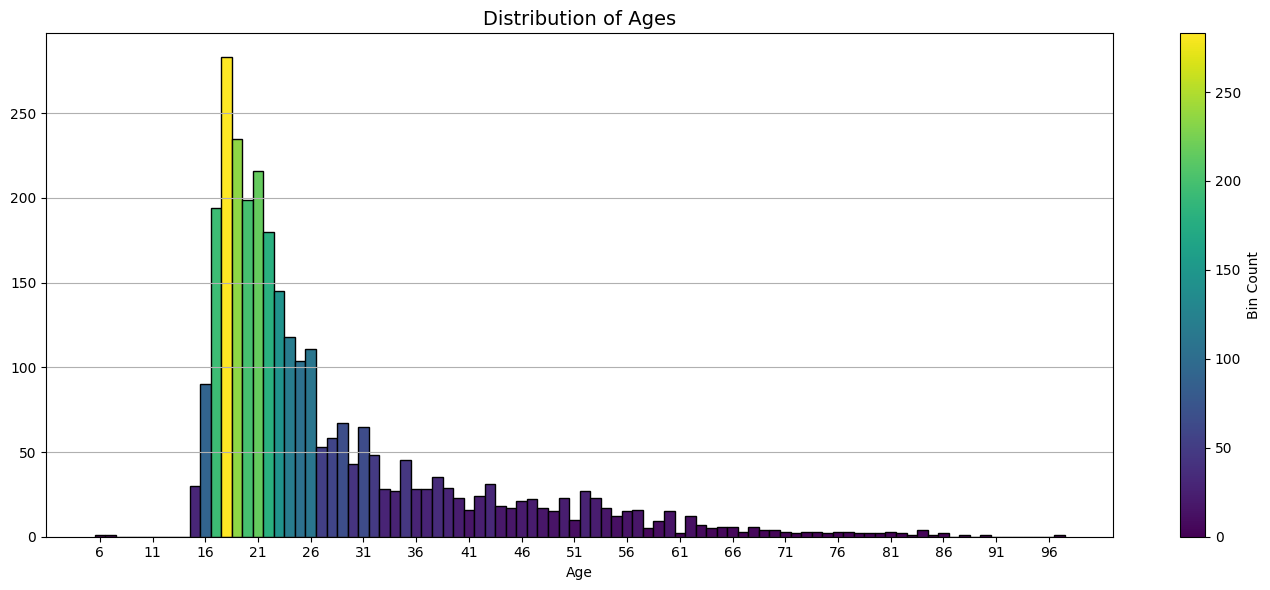

In [ ]:
TARGET = df_dev_copy["target"].copy()

bins = np.arange(TARGET.min() - 0.5, TARGET.max() + 1.5, 1)

fig, ax = plt.subplots(figsize=(14, 6))
N, bins, patches = ax.hist(TARGET, bins=bins, edgecolor="black", align='mid')
norm = mcolors.Normalize(vmin=N.min(), vmax=N.max())
cmap = cm.viridis

for count, patch in zip(N, patches):
    patch.set_facecolor(cmap(norm(count)))

ax.set_title("Distribution of Ages", fontsize=14)
ax.set_xlabel("Age")
ax.set_xticks(range(int(TARGET.min()), int(TARGET.max()) + 1, 5))
ax.grid(axis='y')

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Bin Count")

fig.tight_layout()
plt.show()

The target variable's distribution reveals a significant imbalance, which likely reflects a real-world scenario. The majority of data points fall within the age range of 16-26, where the model is expected to perform well due to the abundance of training examples. However, this imbalance poses a challenge for accurately predicting ages outside this range, particularly for older individuals, as their representation in the dataset is sparse.

To address this issue, a sampling technique can be introduced into the model pipeline. One approach is to generate synthetic data, which would augment the population of low-frequency targets and ensure better representation across the entire age range. Another option is to diminish the prevalence of highly frequent targets by reducing their frequency through under-sampling. 

Given that the dataset is not particularly large and may involve the exclusion of a few outliers, data augmentation appears to be the most promising choice. This method retains all existing data while enriching the minority classes, offering a more comprehensive and balanced dataset for training. Nevertheless, both data augmentation and under-sampling will be tested to assess their impact on the model's overall performance and its ability to generalize effectively.

### Categorical Data (Vanilla Development Set v.s. Evaluation Set)

#### Gender

In [9]:
dev_gender = df_dev_copy["gender"].copy()
eval_gender = df_eval_copy["gender"].copy()

dev_labels, dev_sizes = dev_gender.value_counts().index, dev_gender.value_counts().values
eval_labels, eval_sizes = eval_gender.value_counts().index, eval_gender.value_counts().values

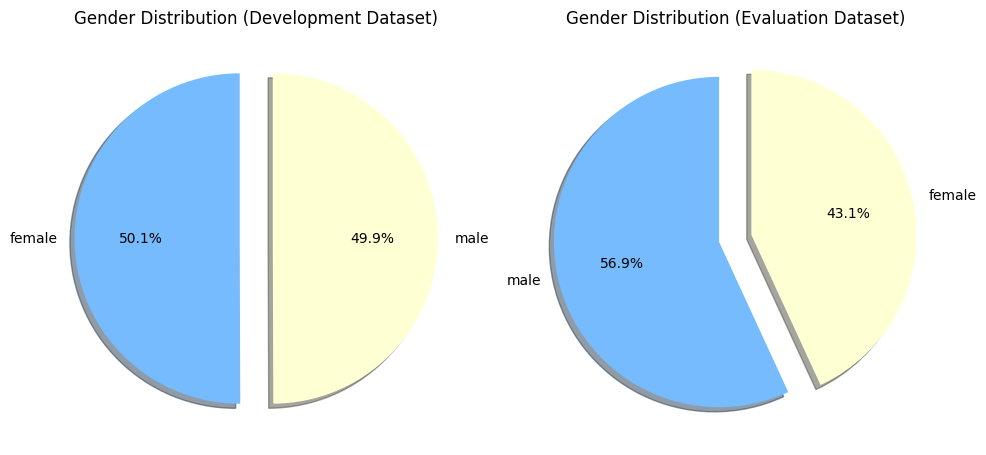

In [ ]:
pie_colors = ["xkcd:sky blue", "xkcd:eggshell"]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# development dataset pie chart
axes[0].pie(dev_sizes, labels=dev_labels, autopct='%1.1f%%', 
            explode=[0.1] * len(dev_labels), shadow=True, startangle=90, colors=pie_colors)
axes[0].set_title("Gender Distribution (Development Dataset)")

# development dataset pie chart
axes[1].pie(eval_sizes, labels=eval_labels, autopct='%1.1f%%', 
            explode=[0.1] * len(eval_labels), shadow=True, startangle=90, colors=pie_colors)
axes[1].set_title("Gender Distribution (Evaluation Dataset)")

plt.tight_layout()
plt.show()

#### Age Distribution Among Genders

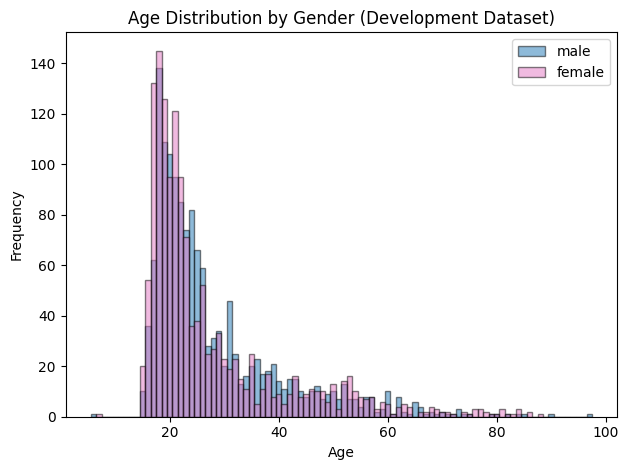

In [11]:
age_male = TARGET[df_dev_copy["gender"] == "male"]
age_female = TARGET[df_dev_copy["gender"] == "female"]

# bins for both distributions
bins = np.arange(min(age_male.min(), age_female.min()) - 0.5, 
                 max(age_male.max(), age_female.max()) + 1.5, 1)

plt.hist(age_male, bins=bins, edgecolor="black", align="mid", color="tab:blue", alpha=.5, label="male")
plt.hist(age_female, bins=bins, edgecolor="black", align="mid", color="tab:pink", alpha=.5, label="female")

plt.title("Age Distribution by Gender (Development Dataset)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

#### Ethnicity

In [12]:
# extract ethnicity columns
dev_ethnicity = df_dev_copy["ethnicity"]
eval_ethnicity = df_eval_copy["ethnicity"]

# number of unqiue ethnicities
dev_unique_ethnicity = set(dev_ethnicity.unique())
eval_unique_ethnicity = set(eval_ethnicity.unique())

print(f"Number of different ethnicities in development dataset: {len(dev_unique_ethnicity)}")
print(f"Number of different ethnicities in evaluation dataset: {len(eval_unique_ethnicity)}")

# compare how many ethnicities are shared among the development and evaluation set
common_ethnicities = dev_unique_ethnicity & eval_unique_ethnicity
print(f"Number of common ethnicities between development and evaluation set: {len(common_ethnicities)}")

Number of different ethnicities in development dataset: 165
Number of different ethnicities in evaluation dataset: 73
Number of common ethnicities between development and evaluation set: 17


In [13]:
print(f"{'Ethnicity':<15}{'Development Set':<20}{'Evaluation Set':<20}")
print("-" * 55)

for ethnicity in common_ethnicities:
    dev_n_instances = (df_dev_copy["ethnicity"] == ethnicity).sum()
    eval_n_instances = (df_eval_copy["ethnicity"] == ethnicity).sum()
    print(f"{ethnicity:<15}{dev_n_instances:<20}{eval_n_instances:<20}")


Ethnicity      Development Set     Evaluation Set      
-------------------------------------------------------
indian         2                   2                   
kanuri         1                   4                   
congolese      13                  1                   
annang         2                   2                   
afemai         2                   1                   
hausa          11                  1                   
yoruba         12                  5                   
satawalese     1                   1                   
igbo           1081                232                 
nigerian       5                   1                   
cameroonian    2                   1                   
igala          22                  4                   
ukwani         2                   1                   
ibibio         27                  2                   
ijaw           2                   1                   
ikwerre        2                   1            

The dataset contains a significant number of ethnicities, with 165 unique ethnicities in the development set and 73 in the evaluation set. However, only 17 ethnicities are common between the two sets, which raises concerns about the relevance of this feature for the task. Notably, the Igbo ethnicity is the only one with a significant presence in both sets, while the others appear sparsely or are exclusive to one of the sets.

This imbalance suggests that the ethnicity feature might not contribute meaningfully to the model's generalization ability. If the model learns patterns specific to ethnicities present only in the development set, it risks overfitting and failing to generalize when exposed to the evaluation set, where those ethnicities are absent.

To address this, a potential solution is to transform the ethnicity feature into a binary variable, representing whether an individual is Igbo or not. This approach has several advantages:

Dimensionality Reduction: By avoiding one-hot encoding for a large number of ethnicities, the feature space becomes smaller, making the model simpler and potentially more efficient.
Improved Generalization: Reducing the feature to a binary value may prevent the model from overfitting to the sparse and imbalanced ethnicity data, focusing instead on other, more relevant features.
In summary, transforming the ethnicity feature into a binary indicator for being Igbo or not is a pragmatic choice. This change reduces dimensionality and ensures the model is less reliant on ethnicity-specific patterns, particularly for ethnicities that are not shared between the development and evaluation sets. 

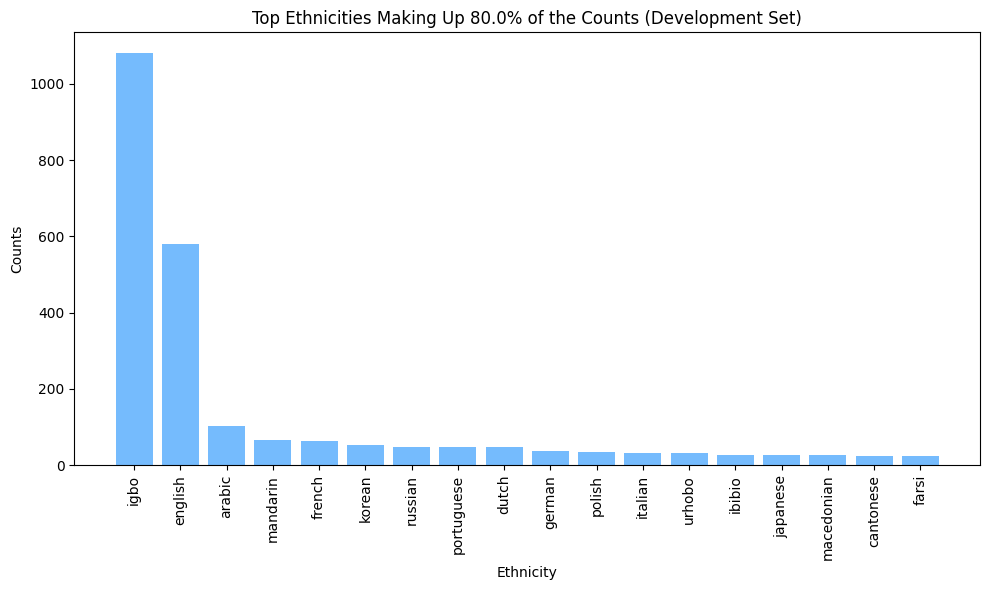

In [14]:
dev_ethnicity_counts, dev_ethnicity_labels = dev_ethnicity.value_counts().values, dev_ethnicity.value_counts().index

# Compute cumulative sum and filter based on the 'perc' threshold
total = dev_ethnicity_counts.sum()
cumulative = dev_ethnicity_counts.cumsum()
perc = 0.80
filter_mask = cumulative <= total * perc

# Filter the counts and labels
dev_reduced_ethnicity_counts = dev_ethnicity_counts[filter_mask]
dev_reduced_ethnicity_labels = dev_ethnicity_labels[filter_mask]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(dev_reduced_ethnicity_labels, dev_reduced_ethnicity_counts, color='xkcd:sky blue')
ax.set_xticks(range(len(dev_reduced_ethnicity_labels)))
ax.set_xticklabels(dev_reduced_ethnicity_labels, rotation=90)
ax.set_xlabel("Ethnicity")
ax.set_ylabel("Counts")
ax.set_title(f"Top Ethnicities Making Up {perc * 100}% of the Counts (Development Set)")
plt.tight_layout()
plt.show()

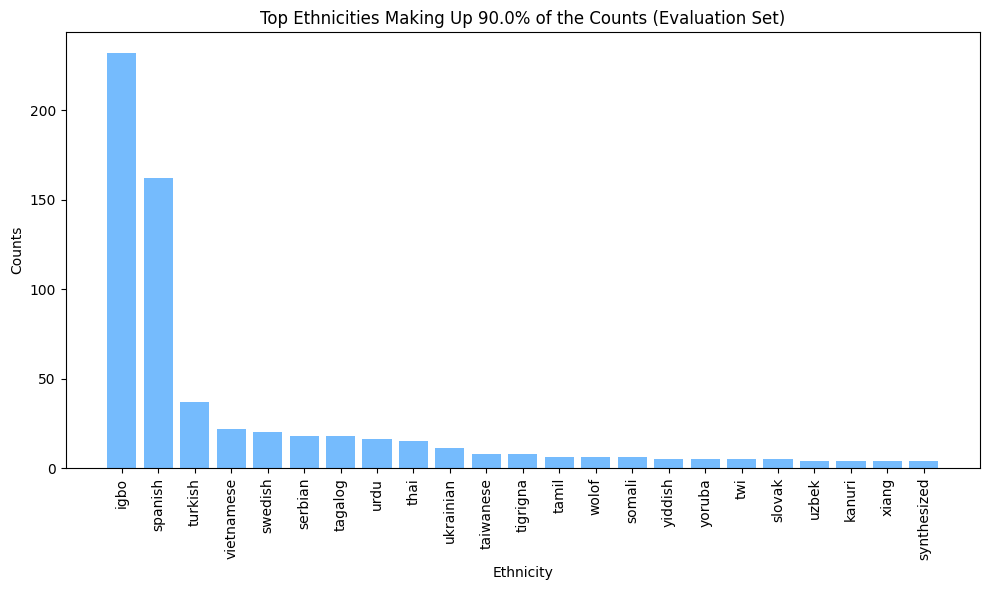

In [15]:
eval_ethnicity_counts, eval_ethnicity_labels = eval_ethnicity.value_counts().values, eval_ethnicity.value_counts().index

# Compute cumulative sum and filter based on the 'perc' threshold
total = eval_ethnicity_counts.sum()
cumulative = eval_ethnicity_counts.cumsum()

perc = 0.9
filter_mask = cumulative <= total * perc

# Filter the counts and labels
eval_reduced_ethnicity_counts = eval_ethnicity_counts[filter_mask]
eval_reduced_ethnicity_labels = eval_ethnicity_labels[filter_mask]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(eval_reduced_ethnicity_labels, eval_reduced_ethnicity_counts, color='xkcd:sky blue')
ax.set_xticks(range(len(eval_reduced_ethnicity_labels)))
ax.set_xticklabels(eval_reduced_ethnicity_labels, rotation=90)
ax.set_xlabel("Ethnicity")
ax.set_ylabel("Counts")
ax.set_title(f"Top Ethnicities Making Up {perc * 100}% of the Counts (Evaluation Set)")
plt.tight_layout()
plt.show()

### Numerical Data (Vanilla Development Set v.s. Evaluation Set)

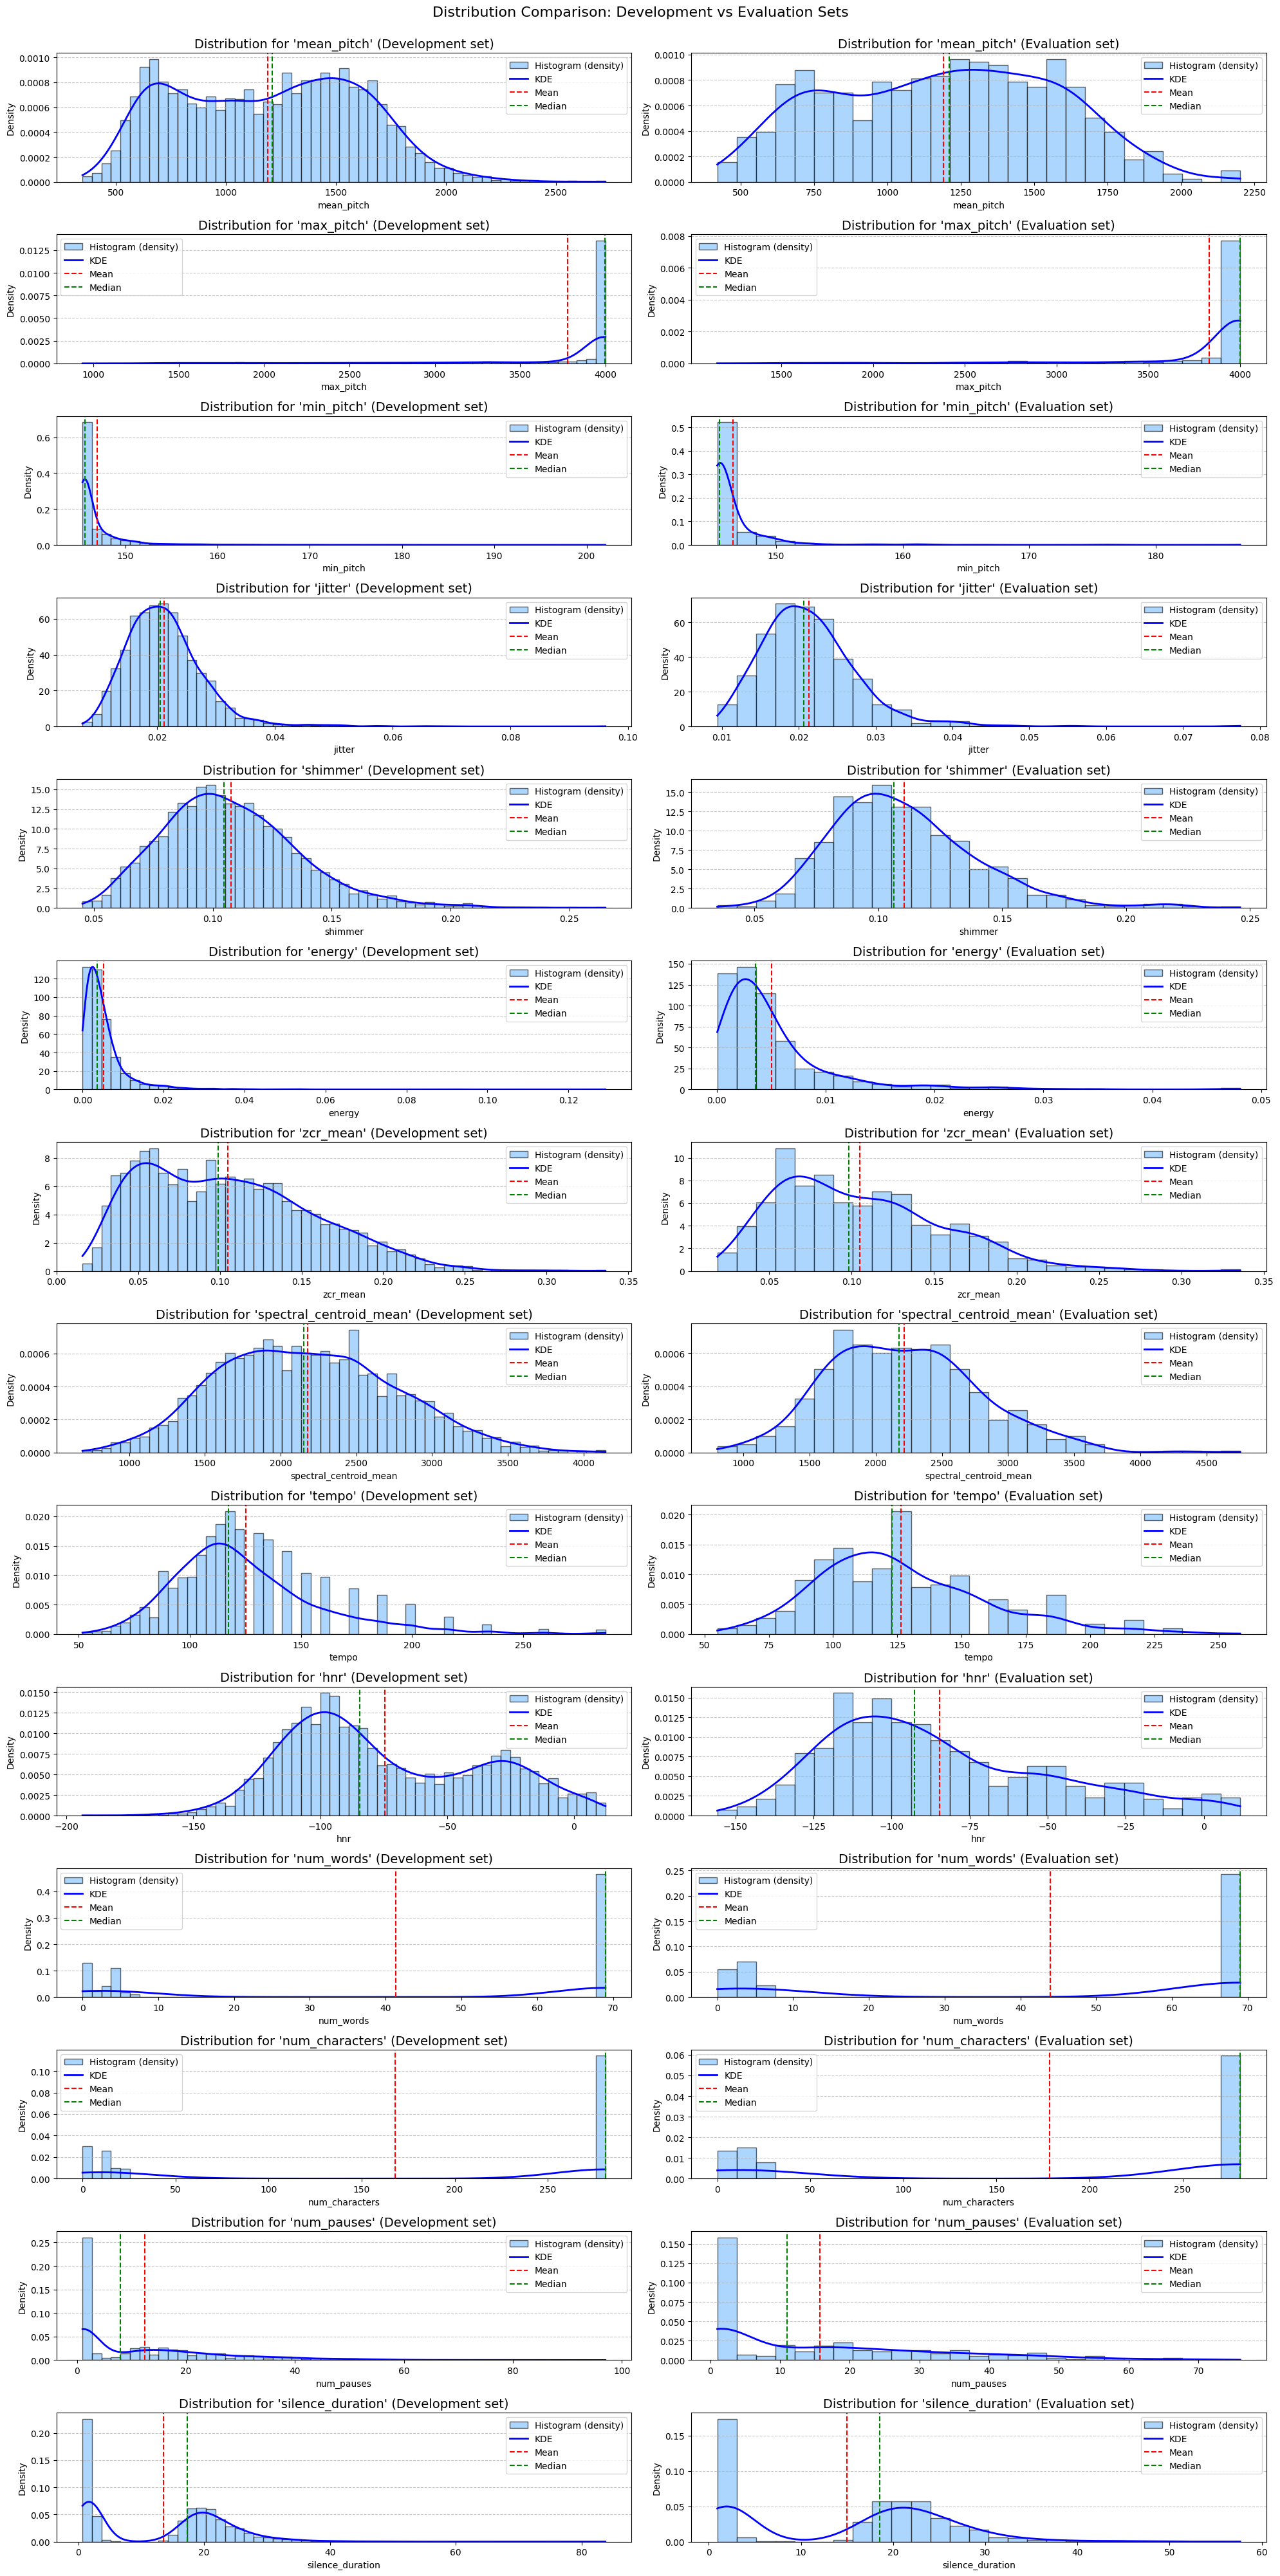

In [16]:
# Numerical features names for column indexing
NUMERICAL_FEATURES = [column for column in df_dev_copy.columns if (df_dev_copy[column].dtype != "object") & (column != "target")]

fig, axes = plt.subplots(len(NUMERICAL_FEATURES), 2, figsize=(20, 40))

for i, feature in enumerate(NUMERICAL_FEATURES):

    # extract relative data
    dev_data = df_dev_copy[feature]
    eval_data = df_eval_copy[feature]

    # -----------------
    # DEVELOPMENT SET
    # -----------------

    # histogram
    axes[i, 0].hist(dev_data, bins="sqrt", density=True, edgecolor="black", alpha=0.6, color="xkcd:sky blue", label="Histogram (density)")

    # kde distribution
    kde = gaussian_kde(dev_data)
    x_vals = np.linspace(dev_data.min(), dev_data.max(), dev_data.shape[0])
    y_vals = kde(x_vals)
    axes[i, 0].plot(x_vals, y_vals, color='blue', linewidth=2, label='KDE')

    # mean & median
    mean_val = dev_data.mean()
    median_val = dev_data.median()
    axes[i, 0].axvline(mean_val, color='red', linestyle='--', label='Mean')
    axes[i, 0].axvline(median_val, color='green', linestyle='--', label='Median')

    axes[i, 0].set_title(f"Distribution for '{feature}' (Development set)", fontsize=14)
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel("Density")
    axes[i, 0].legend()
    axes[i, 0].grid(axis='y', linestyle='--', alpha=0.7)


    # -----------------
    # EVALUATION SET
    # -----------------
    
    # histogram
    axes[i, 1].hist(eval_data, bins="sqrt", density=True, edgecolor="black", alpha=0.6, color="xkcd:sky blue", label="Histogram (density)")

    # kde distribution
    kde = gaussian_kde(eval_data)
    x_vals = np.linspace(eval_data.min(), eval_data.max(), eval_data.shape[0])
    y_vals = kde(x_vals)
    axes[i, 1].plot(x_vals, y_vals, color='blue', linewidth=2, label='KDE')

    # mean & median
    mean_val = eval_data.mean()
    median_val = eval_data.median()
    axes[i, 1].axvline(mean_val, color='red', linestyle='--', label='Mean')
    axes[i, 1].axvline(median_val, color='green', linestyle='--', label='Median')

    axes[i, 1].set_title(f"Distribution for '{feature}' (Evaluation set)", fontsize=14)
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel("Density")
    axes[i, 1].legend()
    axes[i, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Distribution Comparison: Development vs Evaluation Sets", fontsize=16, y=1)
plt.tight_layout()
plt.show()

### Univariate Outlier Detection

#### Histogram Inferred ranges

In [17]:
mean_pitch_outliers = df_dev_copy["mean_pitch"] > 2072.56  # 99th percentile
max_pitch_outliers = df_dev_copy["max_pitch"] < 1513.93    # 1st percentile
min_pitch_outlier = df_dev_copy["min_pitch"] > 163.86      # 99th percentile

total_unique_outliers = (mean_pitch_outliers | max_pitch_outliers | min_pitch_outlier).sum()

common_outliers = (mean_pitch_outliers & max_pitch_outliers & min_pitch_outlier).sum()

print(f"Total unique outliers: {total_unique_outliers}")
print(f"Common outliers: {common_outliers}")

Total unique outliers: 89
Common outliers: 0


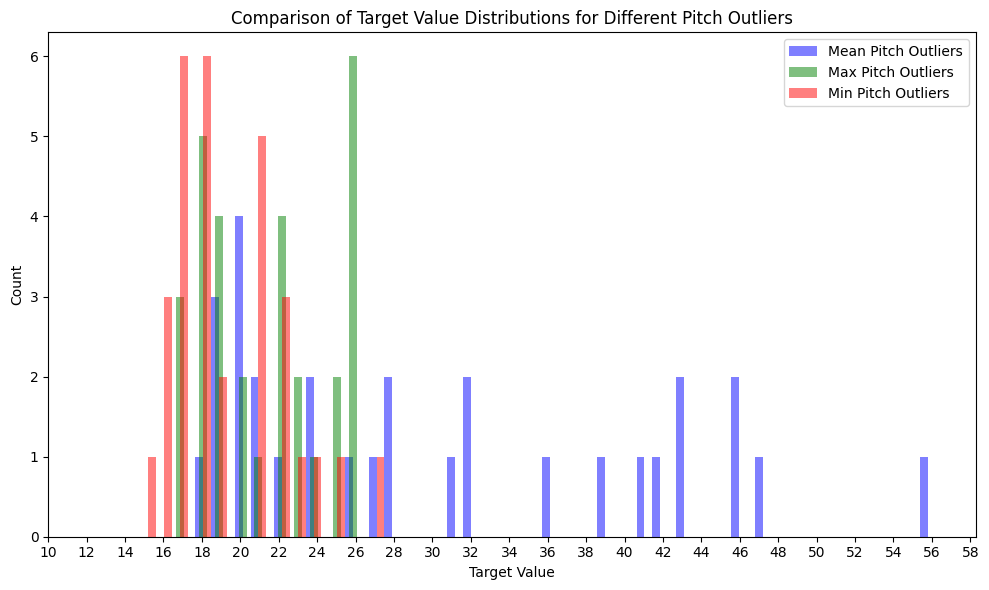

In [ ]:
mean_pitch_target = df_dev_copy["target"][mean_pitch_outliers]
max_pitch_target = df_dev_copy["target"][max_pitch_outliers]
min_pitch_target = df_dev_copy["target"][min_pitch_outlier]

all_data = np.concatenate([mean_pitch_target, max_pitch_target, min_pitch_target])
common_min, common_max = all_data.min(), all_data.max()

plt.figure(figsize=(10, 6))
plt.hist(mean_pitch_target, range=(common_min, common_max), bins=100, alpha=0.5, color='blue',  label='Mean Pitch Outliers', align="left")
plt.hist(max_pitch_target,   range=(common_min, common_max), bins=100, alpha=0.5, color='green', label='Max Pitch Outliers', align="mid")
plt.hist(min_pitch_target,   range=(common_min, common_max), bins=100, alpha=0.5, color='red',   label='Min Pitch Outliers', align="right")

plt.xlabel("Target Value")
plt.xticks(range(10, 60, 2))
plt.ylabel("Count")
plt.title("Comparison of Target Value Distributions for Different Pitch Outliers")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
num_pauses_outliers = df_dev_copy["num_pauses"] > 80 # Over 99th percentile
silence_duration_outliers = df_dev_copy["num_pauses"] > 60 # Over 99th percentile

total_unique_outliers = (num_pauses_outliers | silence_duration_outliers).sum()
common_outliers = (num_pauses_outliers & silence_duration_outliers).sum()

print(f"Total unique outliers: {total_unique_outliers}")
print(f"Common outliers: {common_outliers}")

Total unique outliers: 20
Common outliers: 4


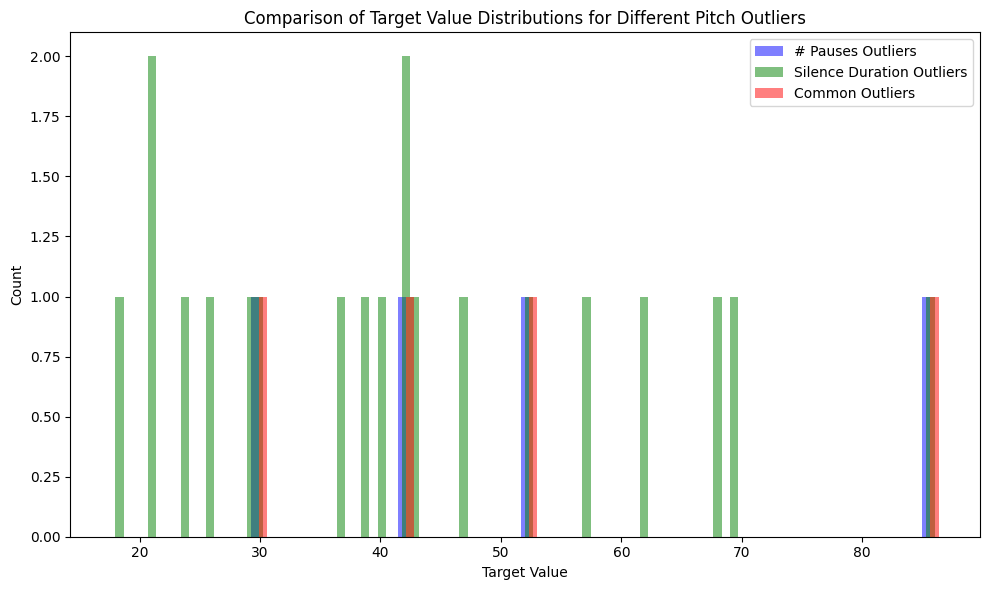

In [ ]:
num_pauses_target = df_dev_copy["target"][num_pauses_outliers]
silence_duration_target = df_dev_copy["target"][silence_duration_outliers]
common_targets = df_dev_copy["target"][num_pauses_outliers & silence_duration_outliers]

all_data = np.concatenate([num_pauses_target, silence_duration_target, common_targets])
common_min, common_max = all_data.min(), all_data.max()

plt.figure(figsize=(10, 6))
plt.hist(num_pauses_target, range=(common_min, common_max), bins=100, alpha=0.5, color='blue',  label='# Pauses Outliers', align="left")
plt.hist(silence_duration_target,   range=(common_min, common_max), bins=100, alpha=0.5, color='green', label='Silence Duration Outliers', align="mid")
plt.hist(common_targets,   range=(common_min, common_max), bins=100, alpha=0.5, color='red',   label='Common Outliers', align="right")

plt.xlabel("Target Value")
plt.ylabel("Count")
plt.title("Comparison of Target Value Distributions for Different Pitch Outliers")
plt.legend()
plt.tight_layout()
plt.show()

#### Boxplot Inferred Ranges 

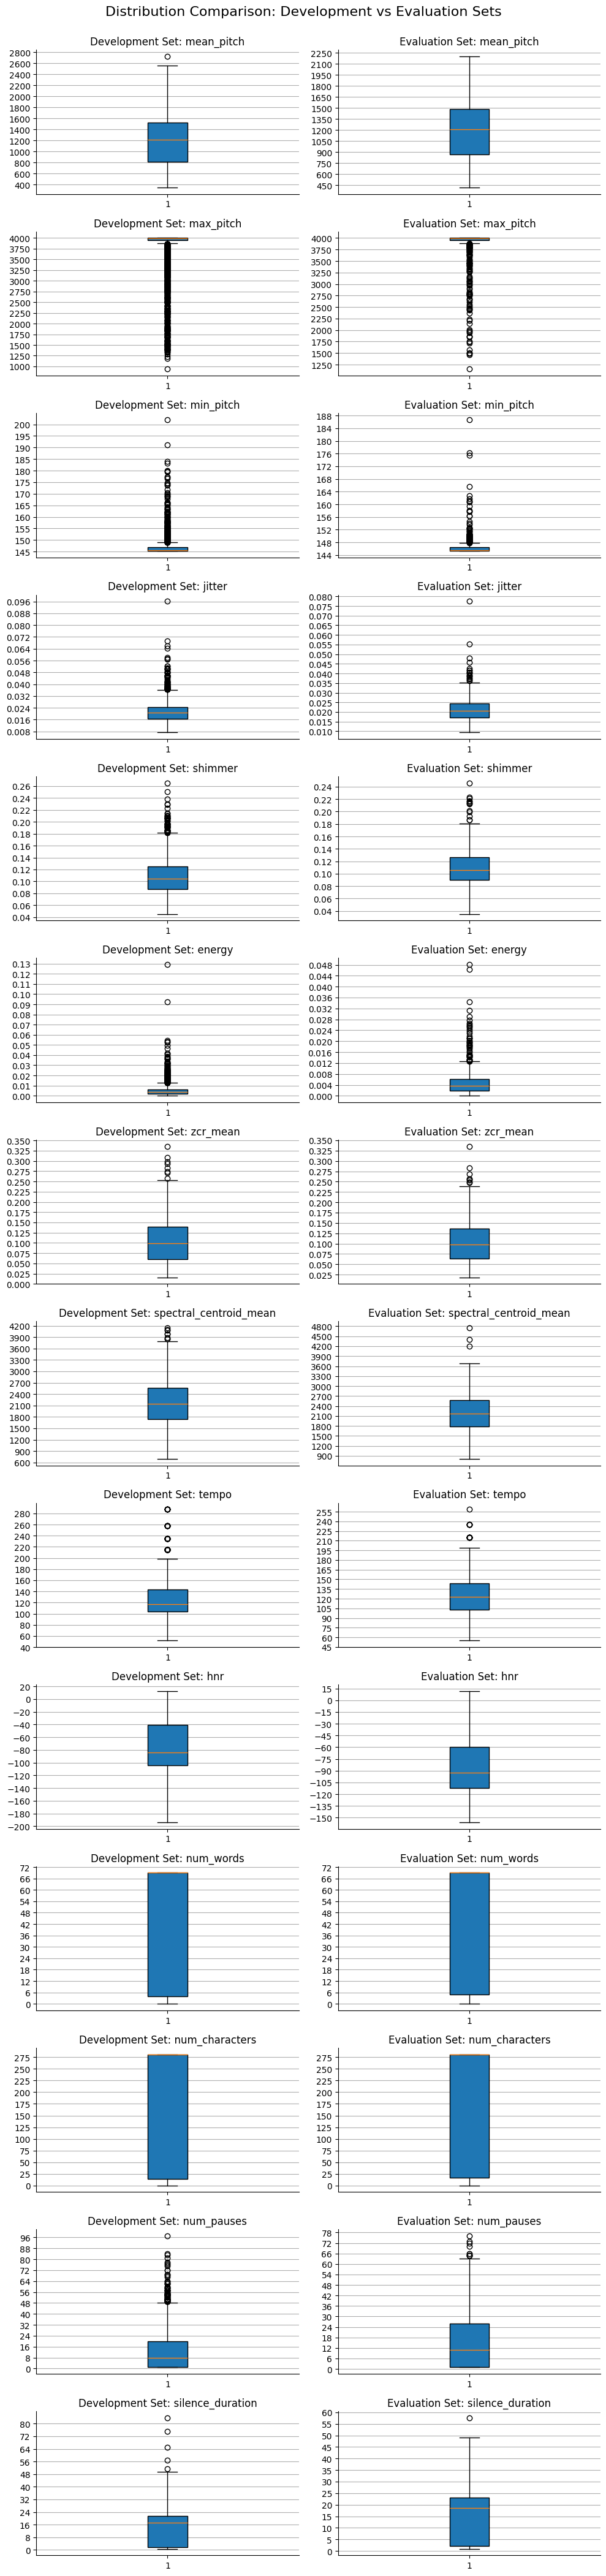

In [21]:
fig, axes = plt.subplots(len(NUMERICAL_FEATURES), 2, figsize=(10, len(NUMERICAL_FEATURES)*3))
plt.suptitle("Distribution Comparison: Development vs Evaluation Sets", fontsize=16, y=1)

for i, feature in enumerate(NUMERICAL_FEATURES):
    dev_data = df_dev_copy[feature]
    eval_data = df_eval_copy[feature]
    
    # --- Development Set ---
    axes[i, 0].boxplot(dev_data, patch_artist=True)
    axes[i, 0].set_title(f"Development Set: {feature}", fontsize=12)
    axes[i, 0].yaxis.set_major_locator(mticker.MaxNLocator(15))  # up to 15 y-ticks
    axes[i, 0].grid(axis='y')  # only horizontal grid
    axes[i, 0].spines['top'].set_visible(False)
    axes[i, 0].spines['right'].set_visible(False)
    
    # --- Evaluation Set ---
    axes[i, 1].boxplot(eval_data, patch_artist=True)
    axes[i, 1].set_title(f"Evaluation Set: {feature}", fontsize=12)
    axes[i, 1].yaxis.set_major_locator(mticker.MaxNLocator(15))
    axes[i, 1].grid(axis='y')
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [22]:
candidate_mean_pitch_outliers = df_dev_copy["mean_pitch"] > 2250 
candidate_max_pitch_outliers = df_dev_copy["max_pitch"] < 1300   
candidate_min_pitch_outliers = df_dev_copy["min_pitch"] > 188    

total_unique_outliers = (candidate_mean_pitch_outliers | candidate_max_pitch_outliers | candidate_min_pitch_outliers).sum()
print(f"Total unique outliers: {total_unique_outliers}")

Total unique outliers: 15


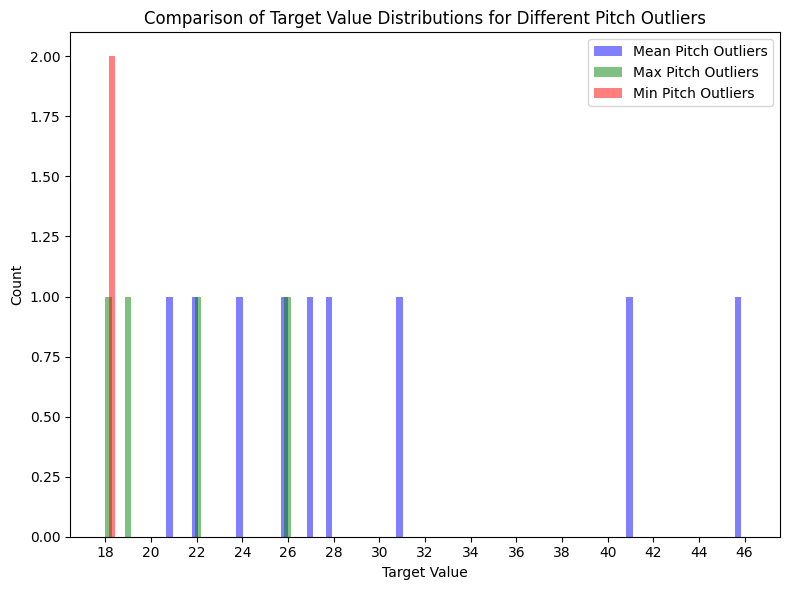

In [ ]:
# target values for each type of outlier
mean_pitch_target = df_dev_copy["target"][candidate_mean_pitch_outliers]
max_pitch_target = df_dev_copy["target"][candidate_max_pitch_outliers]
min_pitch_target = df_dev_copy["target"][candidate_min_pitch_outliers]

all_data = np.concatenate([mean_pitch_target, max_pitch_target, min_pitch_target])
common_min, common_max = all_data.min(), all_data.max()

plt.figure(figsize=(8, 6))
plt.hist(mean_pitch_target, range=(common_min, common_max), bins=100, alpha=0.5, color='blue',  label='Mean Pitch Outliers', align="left")
plt.hist(max_pitch_target,   range=(common_min, common_max), bins=100, alpha=0.5, color='green', label='Max Pitch Outliers', align="mid")
plt.hist(min_pitch_target,   range=(common_min, common_max), bins=100, alpha=0.5, color='red',   label='Min Pitch Outliers', align="right")

plt.xlabel("Target Value")
plt.xticks(np.arange(common_min, common_max + 1, 2))
plt.ylabel("Count")
plt.title("Comparison of Target Value Distributions for Different Pitch Outliers")
plt.legend()
plt.tight_layout()
plt.show()

### Multivariate Outliers Detection (DBSCAN approach)

In [24]:
# data to feed the model
dbscan_data = df_dev_copy[NUMERICAL_FEATURES].copy().astype("float32")
dbscan_data_scaled = StandardScaler().fit_transform(dbscan_data)

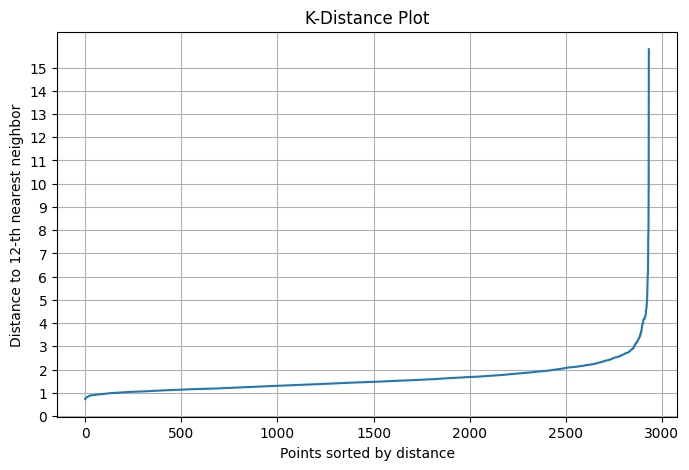

In [ ]:
neighbors = NearestNeighbors(n_neighbors=12) 
neighbors_fit = neighbors.fit(dbscan_data_scaled)
distances, indices = neighbors.kneighbors(dbscan_data_scaled)
distances = np.sort(distances[:, -1])  

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title("K-Distance Plot")
plt.yticks(range(0,16,1))
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to {}-th nearest neighbor".format(12))
plt.grid()
plt.show()

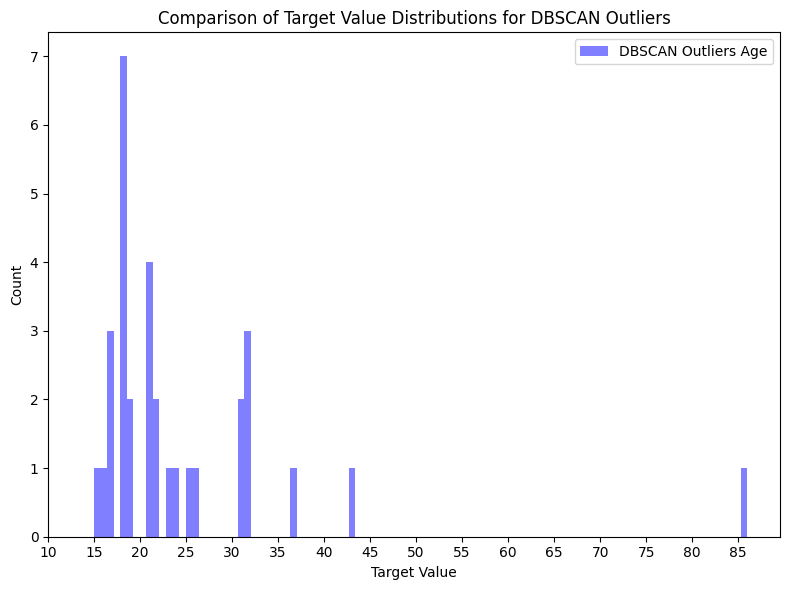

In [ ]:
model = DBSCAN(eps=3, min_samples=15, metric="euclidean")
model.fit(dbscan_data_scaled)

outliers_df = df_dev_copy[model.labels_ == -1]
clusters_df = df_dev_copy[model.labels_ != -1]

plt.figure(figsize=(8, 6))
plt.hist(outliers_df["target"], bins = 100, alpha=0.5, color='blue',  label='DBSCAN Outliers Age')
plt.xlabel("Target Value")
plt.xticks(range(10, 90, 5))
plt.ylabel("Count")
plt.title("Comparison of Target Value Distributions for DBSCAN Outliers")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
idx_max_pitch_outliers = df_dev_copy[candidate_max_pitch_outliers].index
idx_mean_pitch_outliers = df_dev_copy[candidate_mean_pitch_outliers].index
idx_min_pitch_outliers = df_dev_copy[candidate_min_pitch_outliers].index
idx_dbscan_outliers = outliers_df[outliers_df["target"] < 80].index

all_outliers_indeces = set(idx_dbscan_outliers) | set(idx_max_pitch_outliers) | set(idx_mean_pitch_outliers) | set(idx_min_pitch_outliers) # | 
common_outliers_indeces = set(idx_dbscan_outliers) & set(idx_max_pitch_outliers) & set(idx_mean_pitch_outliers) & set(idx_min_pitch_outliers)
outlier_indices_list = list(all_outliers_indeces)

print(f"Total unique outliers: {len(all_outliers_indeces)}")
print(f"Common outliers: {len(common_outliers_indeces)}")

Total unique outliers: 43
Common outliers: 0


In [28]:
def remove_outliers(idx_list = all_outliers_indeces, df=None):
    return df.drop(index=idx_list)

### Feature Correlation Analysis

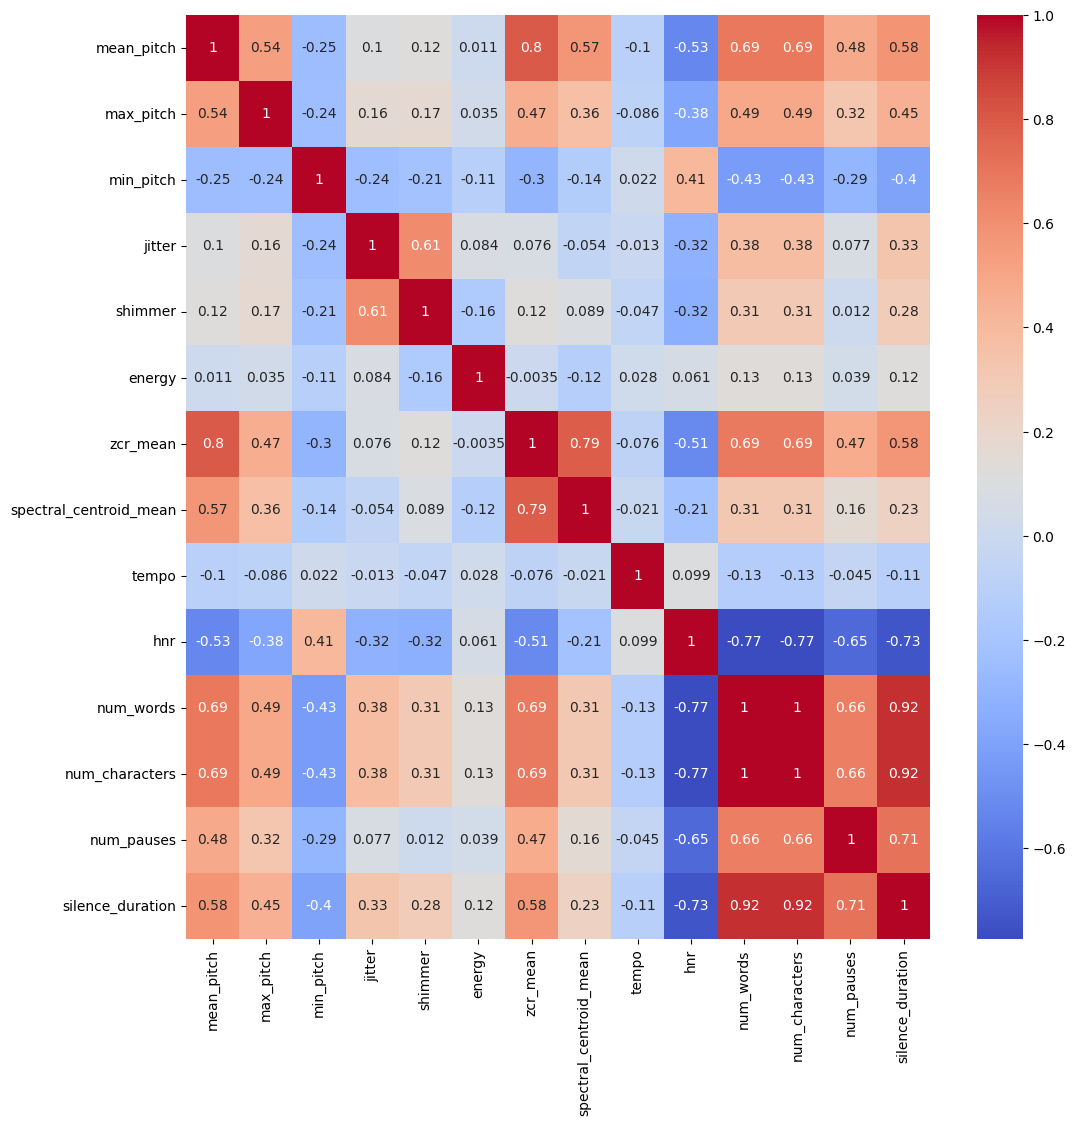

In [29]:
temp = df_dev_copy[NUMERICAL_FEATURES]
corr = temp.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.show()

The features `num_words` and `num_characters` exhibit a strong linear relationship and show similar correlations with other variables in the dataset. As a result, one of these features can be removed without any significant loss of information, as the retained feature will adequately represent the shared information between the two.

### Feature Importance Analysis (RandomForest)

#### Vanilla Dataset

In [30]:
def rmv_outliers(df):
    data = df.copy()
    data = remove_outliers(df=data)
    data["isMale"] = data["gender"].apply(lambda x: 1 if x=="male" else 0)
    data["isIgbo"] = data["ethnicity"].apply(lambda x: 1 if x=="igbo" else 0)
    data.drop(columns=["gender", "ethnicity"], inplace=True)
    X, y = data.drop(columns=["target"]), data["target"]
    float_cols = [col for col in X.columns if X[col].dtype == "float"]
    X[float_cols] = StandardScaler().fit_transform(X[float_cols])
    return X, y

X, y = rmv_outliers(df_dev_copy)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)
predict = rf.predict(X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=predict)

print(f"RMSE: {rmse}")
sorted(zip([col for col in X.columns], rf.feature_importances_), key=lambda x: x[1], reverse=True)

RMSE: 11.487920524648324


[('silence_duration', 0.3604890224436953),
 ('jitter', 0.07552027383298451),
 ('hnr', 0.06340837775063592),
 ('spectral_centroid_mean', 0.0630699215154099),
 ('mean_pitch', 0.0601992181740043),
 ('energy', 0.057679902839192984),
 ('shimmer', 0.057117700812808966),
 ('max_pitch', 0.055363470494079664),
 ('min_pitch', 0.05498569658771308),
 ('zcr_mean', 0.05224365808785418),
 ('num_pauses', 0.04891565343497488),
 ('tempo', 0.038515279951231565),
 ('isMale', 0.009893954314791037),
 ('num_characters', 0.0012305041003890173),
 ('num_words', 0.0010078635215566407),
 ('isIgbo', 0.0003595021386780398)]

In [31]:
def rmv_outliers_and_cols(df):
    data = df.copy()
    data = remove_outliers(df=data)
    data["isMale"] = data["gender"].apply(lambda x: 1 if x=="male" else 0)
    data.drop(columns=["gender", "ethnicity", "num_words"], inplace=True)
    X, y = data.drop(columns=["target"]), data["target"]
    float_cols = [col for col in X.columns if X[col].dtype == "float"]
    X[float_cols] = StandardScaler().fit_transform(X[float_cols])
    return X, y

X, y = rmv_outliers(df_dev_copy)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)
rf.fit(X_train, y_train)
train_predict = rf.predict(X_train)
train_rmse = root_mean_squared_error(y_true=y_train, y_pred=train_predict)
test_predict = rf.predict(X_test)
test_rmse = root_mean_squared_error(y_true=y_test, y_pred=test_predict)
print(f"RMSE on TRAIN: {train_rmse} and TEST: {test_rmse} with full columns")

X, y = rmv_outliers_and_cols(df_dev_copy)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

rf.fit(X_train, y_train)
train_predict = rf.predict(X_train)
train_rmse = root_mean_squared_error(y_true=y_train, y_pred=train_predict)
test_predict = rf.predict(X_test)
test_rmse = root_mean_squared_error(y_true=y_test, y_pred=test_predict)

print(f"RMSE on TRAIN: {train_rmse} and TEST: {test_rmse} after removing 'isIgbo' and 'num_words'")

RMSE on TRAIN: 4.124328503188736 and TEST: 11.487920524648324 with full columns
RMSE on TRAIN: 4.1149430633239374 and TEST: 11.536584733352424 after removing 'isIgbo' and 'num_words'


Removing the ethnicity column and the num_words columns doesn't affect the performance, thus can we consider removing it to reduce the dimensionality of our dataset

#### Full Dataset (Vanilla dataset + extracted features from audio recordings)

In [32]:
df_dev_full = pd.concat(
    [
        df_dev.drop(columns=["spectral_centroid_mean"]),
        df_dev_melspectrogram,
        df_dev_mfcc_and_deltas,
        df_dev_fundamental_freq,
        df_dev_spectral_features,
        df_dev_spectral_contrast
    ],
    axis=1
)

df_dev_full = remove_outliers(df=df_dev_full)

EXTRACTED_COLUMNS = list(df_dev_melspectrogram.columns) + list(df_dev_mfcc_and_deltas) + \
                    list(df_dev_fundamental_freq.columns) + list(df_dev_spectral_features.columns) + list(df_dev_spectral_contrast)

transformation = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(categories="auto", drop="first", handle_unknown="ignore"), ["gender"]),
        ("ss_scaler_vanilla", StandardScaler(), ["mean_pitch", "max_pitch", "min_pitch", "jitter", "shimmer", "energy", 
                                                 "zcr_mean", "tempo", "hnr", "silence_duration", "spectral_centroid_mean"]),
        ("mm_scaler", MinMaxScaler(), ["num_characters", "num_pauses"]),
        ("ss_scaler_audio", StandardScaler(), EXTRACTED_COLUMNS)
    ],
    remainder="drop",
    verbose_feature_names_out=False,
    sparse_threshold=0
)

X, y = df_dev_full.drop(columns=["target"]), df_dev_full["target"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
pipeline = make_pipeline(transformation, RandomForestRegressor(300, random_state=42))

pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)

rmse = root_mean_squared_error(y_true=y_test, y_pred=prediction)

print(f"RMSE: {rmse}")
sorted(zip([col for col in X.columns], pipeline[-1].feature_importances_), key=lambda x: x[1], reverse=True)

RMSE: 10.368363675089183


[('hnr', 0.2557883620712576),
 ('delta2_mfcc_4_mean', 0.06545862187571877),
 ('delta_mfcc_4_mean', 0.02666490948540508),
 ('spectral_contrast_0_mean', 0.01630279441623993),
 ('delta_mfcc_1_kurtosis', 0.013317488530928094),
 ('mfcc_2_std', 0.012101716069474255),
 ('delta2_mfcc_10_kurtosis', 0.009438915123240403),
 ('fundamental_frequency_skew', 0.008801179732951615),
 ('delta_mfcc_1_std', 0.007640436145066632),
 ('melspectrogram_melspectrogram_mid_mean_freq_mean', 0.007372544472456384),
 ('delta2_mfcc_1_mean', 0.007048134293630139),
 ('delta2_mfcc_3_mean', 0.006197660314361354),
 ('mfcc_12_kurtosis', 0.0056888646204595675),
 ('mfcc_7_mean', 0.005609585913169954),
 ('delta2_mfcc_3_kurtosis', 0.005309140069710165),
 ('delta_mfcc_9_kurtosis', 0.00526584609493889),
 ('spectral_contrast_6_kurtosis', 0.0052337657434946405),
 ('spectral_contrast_0_kurtosis', 0.0051159071854793015),
 ('delta_mfcc_9_skew', 0.004990099859732671),
 ('melspectrogram_melspectrogram_low_mean_freq_kurtosis',
  0.00498

We could argue that dropping num_character could  reduce the dimensionality further, even though we are working with a dataset of over 250 columns. For consistency, and by following the assumption that num_characters is a byproduct of the length of the recording, we will drop this aswell 

## Models Selection

### Create Final Dataset

In [43]:
final_df_dev_full = pd.concat(
    [
        df_dev,
        df_dev_melspectrogram,
        df_dev_mfcc_and_deltas,
        df_dev_fundamental_freq,
        df_dev_spectral_features.drop(columns=["spectral_centroid_mean"]),
        df_dev_spectral_contrast
    ],
    axis=1
)

# final_df_dev_full = remove_outliers(df=final_df_dev_full) # NOTE: Outliers removal decreases performance

final_df_eval_full = pd.concat(
    [
        df_eval,
        df_eval_melspectrogram,
        df_eval_mfcc_and_deltas,
        df_eval_fundamental_freq,
        df_eval_spectral_features.drop(columns=["spectral_centroid_mean"]),
        df_eval_spectral_contrast
    ],
    axis=1
)

X, y = final_df_dev_full.drop(columns=["target"]), final_df_dev_full["target"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Pipeline

In [ ]:
EXTRACTED_COLUMNS = list(df_dev_melspectrogram.columns) \
                    + list(df_dev_mfcc_and_deltas) \
                    + list(df_dev_spectral_contrast) \
                    + list(df_dev_fundamental_freq.columns) \
                    + list(df_dev_spectral_features.drop(columns=["spectral_centroid_mean"]).columns)                   

In [45]:
final_transformation = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(categories="auto", drop="first", handle_unknown="ignore"), ["gender"]),
        ("ss_scaler_vanilla", StandardScaler(), ["mean_pitch", "shimmer", "max_pitch", "min_pitch", "jitter", "energy",
                                                 "zcr_mean", "tempo", "hnr", "silence_duration", "spectral_centroid_mean"]),
        ("mm_scaler", MinMaxScaler(), ["num_pauses"]),
        ("ss_scaler_audio", StandardScaler(), EXTRACTED_COLUMNS)
    ],
    remainder="drop",
    verbose_feature_names_out=False,
    sparse_threshold=0
)

### Models Assesment

In [46]:
def evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    return y_pred, rmse, model

In [47]:
def compute_rmse_different_models(X, y, final_transformation):

    random_state = 42
    t = PrettyTable()
    t.field_names = ['model', 'RMSE']

    models = [
        LinearRegression(),
        Lasso(random_state=random_state),
        Ridge(random_state=random_state),
        ElasticNet(random_state=42),
        SVR(gamma='scale'),
        RandomForestRegressor(n_estimators=100, random_state=random_state),
        GradientBoostingRegressor(random_state=random_state),
        CatBoostRegressor(random_seed=random_state, logging_level="Silent"),
    ]

    names = [
        'linreg',
        'lasso',
        'ridge',
        "elastic",
        'svr',
        'rf',
        'gbr',
        'cbr',
    ]

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), test_size=0.2, random_state=42)

    for model, name in zip(models, names):
        model_pipeline = make_pipeline(final_transformation, model)
        _, rmse, _ = evaluate_model(X_train, y_train, X_test, y_test, model_pipeline)
        t.add_row([name, rmse])

    print(t)

compute_rmse_different_models(X=X, y=y, final_transformation=final_transformation)

+---------+--------------------+
|  model  |        RMSE        |
+---------+--------------------+
|  linreg | 9.576542716116307  |
|  lasso  | 10.35002388113884  |
|  ridge  |  9.57259560921826  |
| elastic | 10.197910543818674 |
|   svr   | 10.51523197326472  |
|    rf   |  9.46211269542844  |
|   gbr   |  9.50297797713784  |
|   cbr   |  9.14458521791827  |
+---------+--------------------+


We will approach model hyperparameter tuning using two distinct strategies. First, we will explore classical machine learning models studied in class, leveraging their simplicity and interpretability. Second, we will evaluate the performance of state-of-the-art models such as Gradient Boosting and CatBoost, which are well-suited for handling complex problems like this one, to determine their effectiveness in this context.

## Hyperparameters Tuning

### Classical Regressor Models

In [48]:
model_pipeline = IMBPipeline(
    [
        ("transformation", final_transformation),
        ("sampler", RandomOverSampler(sampling_strategy="minority")),
        ("dim_reduction", PCA(n_components=0.9)),
        ("classifier", RandomForestRegressor(random_state=42))
    ]
)

model_pipeline.fit(X=X_train, y=y_train)
prediction = model_pipeline.predict(X=X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=prediction)
print("RMSE = ", rmse)

RMSE =  10.161790862166248


In [49]:
sampler_configs = [
    {
        'sampler': [None]
    },
    {
        'sampler': [RandomOverSampler(random_state=42)],
        'sampler__sampling_strategy': ['minority', 'not minority']
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA(random_state=42)],
        'dim_reduction__n_components': uniform(0.6, 0.99)
    },
    {
        'dim_reduction': [LinearDiscriminantAnalysis()]
    }
]

classifier_configs = [
    {
        "classifier": [Ridge(random_state=42)],
        "classifier__fit_intercept": [True, False],
        "classifier__alpha": uniform(1e-1, 1e1),
        "classifier__solver": ["auto", "svd", "sag"]
    },
    {
        'classifier': [RandomForestRegressor(n_jobs=-1, random_state=42)],
        'classifier__n_estimators': randint(80, 400),
        'classifier__max_depth': [None] + list(range(3, 6)),
        'classifier__max_features': ['sqrt', 'log2', None]
    }
]

In [50]:
all_configs = []
for configuration in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    all_configs.append((dict(itertools.chain(*(e.items() for e in configuration)))))
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 12'

In [51]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 3,
    cv=4,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

In [52]:
classical_regressor_scores = cross_validate(rs, X_train, y_train, scoring='neg_root_mean_squared_error', cv = 5, return_estimator=True, verbose=3) 

[CV] END ....................................., score=-10.035 total time= 1.9min
[CV] END ......................................, score=-9.589 total time=  53.3s
[CV] END ....................................., score=-11.372 total time= 1.2min
[CV] END ....................................., score=-10.576 total time=  50.8s
[CV] END ....................................., score=-10.745 total time= 2.3min


In [53]:
print('#'*100)
for index, estimator in enumerate(classical_regressor_scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(classical_regressor_scores['test_score'][index])
    print('- '*100)

####################################################################################################
None
None
RandomForestRegressor(max_features=None, n_estimators=241, n_jobs=-1,
                      random_state=42) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 241, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
-10.035478501341979
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
None
None
RandomForestRegressor(max_features='log2', n_estimators=210, n_jobs=-1,
                      random_state=42) {'bootstrap': True, 'ccp_alpha': 0.0, 'cr

In [54]:
for estimator in classical_regressor_scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    rmse_train = root_mean_squared_error(y_train, pred_train)
    rmse_test = root_mean_squared_error(y_test, pred_test)
    print(f'RMSE on training set:{rmse_train}, RMSE on test set:{rmse_test}')

RMSE on training set:3.810900825078548, RMSE on test set:9.411837790225267
RMSE on training set:3.8891580684078644, RMSE on test set:9.844559452673087
RMSE on training set:8.87294951391862, RMSE on test set:9.710107874428424
RMSE on training set:1.9300001411869063, RMSE on test set:9.925979091916187
RMSE on training set:3.8527272198803124, RMSE on test set:9.389302925809892


### Advanced Regressor Models

In [55]:
classifier_configs= [
    {
        'classifier': [GradientBoostingRegressor(random_state=42)],
        'classifier__n_estimators': randint(50,200),
        'classifier__max_depth': [None] + list(range(3, 10)),
    },
    {
        'classifier': [CatBoostRegressor(random_seed=42, loss_function="RMSE", logging_level="Silent")],
        'classifier__iterations': randint(500, 2500),
        'classifier__depth': range(4,8)
    }
]

In [56]:
all_configs = []
for configuration in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    all_configs.append((dict(itertools.chain(*(e.items() for e in configuration)))))
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 12'

In [57]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 3,
    cv=4,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

In [59]:
advanced_regressor_scores = cross_validate(rs, X_train, y_train, scoring='neg_root_mean_squared_error', cv = 3, return_estimator=True, verbose=3) 

[CV] END ......................................, score=-9.394 total time=23.6min
[CV] END ....................................., score=-10.344 total time=16.1min
[CV] END ....................................., score=-10.270 total time=13.5min


In [60]:
print('#'*100)
for index, estimator in enumerate(advanced_regressor_scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(advanced_regressor_scores['test_score'][index])
    print('- '*100)

####################################################################################################
None
None
<catboost.core.CatBoostRegressor object at 0x000002443667DA90> {'loss_function': 'RMSE', 'random_seed': 42, 'logging_level': 'Silent', 'depth': 6, 'iterations': 2206}
-9.394102512898383
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
None
None
<catboost.core.CatBoostRegressor object at 0x0000024436F5D1D0> {'loss_function': 'RMSE', 'random_seed': 42, 'logging_level': 'Silent', 'depth': 7, 'iterations': 2216}
-10.344308665893866
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
None
None
<catboost.core.CatBoostRegressor object at 0x000002443C6C5ED0> {'loss_function': 'RMSE', 'rand

In [61]:
for estimator in advanced_regressor_scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    rmse_train = root_mean_squared_error(y_train, pred_train)
    rmse_test = root_mean_squared_error(y_test, pred_test)
    print(f'RMSE on training set:{rmse_train}, RMSE on test set:{rmse_test}')

RMSE on training set:1.1356011013530174, RMSE on test set:8.960758959419527
RMSE on training set:0.5533963335180566, RMSE on test set:8.873048453694903
RMSE on training set:3.313929065330335, RMSE on test set:9.049206698590641


### Model Evaluation

In [ ]:
classical_regressor_model = IMBPipeline(
    [
        ("transformation",final_transformation),
        ("dim_reduction", LinearDiscriminantAnalysis()),
        ("regressor", RandomForestRegressor(criterion='squared_error', random_state=42))
    ]
)

advanced_regressor_model = IMBPipeline(
    [
        ("transformation", final_transformation),
        ("dim_reduction", LinearDiscriminantAnalysis()),
        ("regressor", CatBoostRegressor(random_seed=42, loss_function="RMSE", logging_level="Silent", od_type="IncToDec"))
    ]
)

classical_regressor_model.fit(X_train, y_train)
advanced_regressor_model.fit(X_train, y_train)

cls_pred = classical_regressor_model.predict(X_test)
adv_pred = advanced_regressor_model.predict(X_test)

cls_rmse = root_mean_squared_error(y_test, cls_pred)
adv_rmse = root_mean_squared_error(y_test, adv_pred)

print(f"RMSE (Classical Regressor): {cls_rmse}")
print(f"RMSE (Advanced Regressor): {adv_rmse}")

RMSE (Classical Regressor): 9.31209780810609
RMSE (Advanced Regressor): 8.70807015255798


In [89]:
def plot_predicted_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, edgecolor=None)
    max_val = max(max(y_true), max(y_pred))
    min_val = min(min(y_true), min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    # plt.title(f'Predicted vs Actual Values ({model_name})')
    plt.xlabel("Actual Value", fontsize=22)
    plt.ylabel("Predicted Value", fontsize=24)
    plt.xticks(fontsize=20, color='black')
    plt.yticks(fontsize=20, color='black')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"figs/predicted_acutal{model_name}.pdf", bbox_inches="tight")
    plt.show()

# plot_predicted_vs_actual(y_test, cls_pred, "RandomForestRegressor")
# plot_predicted_vs_actual(y_test, adv_pred, "CatBoostRegressor")

In [78]:
randomforest_regressor_distributions = {
    "regressor__n_estimators": randint(100, 250),  
    "regressor__min_weight_fraction_leaf": uniform(0.0, 0.2),
    "regressor__min_impurity_decrease": uniform(0.0, 0.02), 
    "regressor__oob_score": [False, True]
}

catboost_regressor_distributions = {
    'regressor__iterations': randint(1800, 2501),  
    'regressor__learning_rate': uniform(0.01, 0.1),    
    'regressor__l2_leaf_reg': randint(1, 3),  
    'regressor__bagging_temperature': uniform(0, 2),  
}

In [ ]:
random_search_rf = RandomizedSearchCV(
    estimator=classical_regressor_model,
    param_distributions=randomforest_regressor_distributions,
    n_iter=100,  
    scoring='neg_root_mean_squared_error',  
    cv=5,  
    random_state=42,
    n_jobs=-1, 
    verbose=3  
)

random_search_rf.fit(X_train, y_train)

print("Best Parameters:\n", random_search_rf.best_params_)
best_rmse_rf = -random_search_rf.best_score_
print("Best RMSE: ", best_rmse_rf)

best_rf_model = random_search_rf.best_estimator_
rf_predictions = best_rf_model.predict(X_test)

rmse_rf = root_mean_squared_error(y_test, rf_predictions)
r2_rf = r2_score(y_test, rf_predictions)

print(f"Test RMSE: {rmse_rf}")
print(f"Test R²: {r2_rf}")

In [ ]:
random_search_cat = RandomizedSearchCV(
    estimator=advanced_regressor_model,
    param_distributions=catboost_regressor_distributions,
    n_iter=2,  
    scoring='neg_root_mean_squared_error',  
    cv=4,  
    random_state=42,
    n_jobs=-1, 
    verbose=3 
)

random_search_cat.fit(X_train, y_train)

print("Best Parameters:\n", random_search_cat.best_params_)
best_rmse_rf = -random_search_cat.best_score_
print("Best RMSE: ", best_rmse_rf)

best_cat_model = random_search_cat.best_estimator_
cat_predictions = best_cat_model.predict(X_test)

rmse_rf = root_mean_squared_error(y_test, best_cat_model)
r2_rf = r2_score(y_test, best_cat_model)

print(f"Test RMSE: {rmse_rf}")
print(f"Test R²: {r2_rf}")

In [ ]:
plot_predicted_vs_actual(y_test, random_search_rf.best_estimator_.predict(X_test), "RandomForestRegressor")
plot_predicted_vs_actual(y_test, random_search_cat.best_estimator_.predict(X_test), "CatBoostRegressor")

In [ ]:
random_search_rf.best_estimator_.fit(X, y)
rf_prediction = random_search_rf.best_estimator_.predict(final_df_eval_full)



In [86]:
random_search_cat.best_estimator_.fit(X, y)
cat_prediction = random_search_cat.best_estimator_.predict(final_df_eval_full)

In [87]:
res = pd.DataFrame({'Id': final_df_eval_full.index, 'Predicted': rf_prediction})
res.to_csv(f'submissions/submission_random_forest.csv', sep=',', index=False)

In [88]:
res = pd.DataFrame({'Id': final_df_eval_full.index, 'Predicted': cat_prediction})
res.to_csv(f'submissions/submission_cat_boost.csv', sep=',', index=False)

## Funny code for ridiculous position

In [86]:
# Mega model super instict: Saffron
classifier_configs = [
    {
        'classifier': [RandomForestRegressor(n_jobs=-1, random_state=42)],
        'classifier__n_estimators': randint(100, 300),
        'classifier__max_depth': [None] + list(randint(3, 6)),
        'classifier__max_features': ['sqrt', 'log2', None]
    },
    {
        'classifier': [GradientBoostingRegressor(random_state=42)],
        'classifier__n_estimators': randint(100, 300),
        'classifier__learning_rate': uniform(0.001, 0.1),
        'classifier__max_depth': [None] + list(randint(3, 7)),
        'classifier__max_features': ['sqrt', 'log2', None]
    },
    {
        'classifier': [CatBoostRegressor(random_seed=42, loss_function="RMSE", logging_level="Silent")],
        'classifier__iterations': randint(500, 2500),
        'classifier__learning_rate': uniform(0.001, 0.1),
        'classifier__depth': randint(6,7,8)
    }
]


In [87]:
all_configs = []
for configuration in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    all_configs.append((dict(itertools.chain(*(e.items() for e in configuration)))))
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 27'

In [88]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

In [89]:
mega_scores = cross_validate(rs, X_train, y_train, scoring='neg_root_mean_squared_error', cv = 3, return_estimator=True, verbose=3) 

[CV] END ......................................, score=-9.517 total time=77.2min
[CV] END ....................................., score=-10.261 total time=82.7min
[CV] END ......................................, score=-9.672 total time=71.4min
[CV] END ....................................., score=-10.948 total time=67.9min
[CV] END ....................................., score=-9.370 total time=124.3min


In [ ]:
print('#'*100)
for index, estimator in enumerate(mega_scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(mega_scores['test_score'][index])
    print('- '*100)

In [ ]:
for estimator in mega_scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    rmse_train = root_mean_squared_error(y_train, pred_train)
    rmse_test = root_mean_squared_error(y_test, pred_test)
    print(f'RMSE on training set:{rmse_train}, RMSE on test set:{rmse_test}')

In [92]:
predictions = list()
for estimator in mega_scores['estimator']:
    estimator.best_estimator_.fit(X, y)
    predictions.append(estimator.best_estimator_.predict(final_df_eval_full))

In [93]:
ids = df_eval.index

for i, pred in enumerate(predictions):
    res = pd.DataFrame({'Id': ids, 'Predicted': pred})
    res.to_csv(f'submissions/submission_{i}.csv', sep=',', index=False)